In [136]:
import pandas as pd
import math
import glob
import matplotlib.pyplot as plt

In [138]:
def process_snap(directory):
    total = []

    for file in glob.glob(directory + '/*.xls'):
        year = pd.read_excel(file, sheet_name=None, skiprows=4, skipfooter=4)
        total.append(process_year_old(year))

    for file in glob.glob(directory + '/*.xlsx'):
        year = pd.read_excel(file, sheet_name=None, skiprows=6, skipfooter=5)
        total.append(process_year_new(year))
    
    return pd.concat(total, axis=0, ignore_index=True)

def process_year_old(year_data):
    ret = []
    for region in year_data:
        if 'US' not in region:
            data = year_data[region]
            data.columns = ['Date', 'Households', 'Persons', 'Benefit / Households', 'Benefit / Persons', 'Cost']
            data.dropna(subset=['Date'], inplace=True)
            data = data[data['Date'].str.contains('Total') == False].to_numpy().tolist()

            i = 1
            current_state = data[0][0]
            while i < len(data) and data[i][0] != region:
                if data[i][1] == '--':
                    i += 1
                    continue

                if math.isnan(data[i][1]):
                    current_state = data[i][0]
                    i += 1
                    continue
                row = data[i] + [current_state] + [region]
                ret.append(row)
                i += 1
    ret = pd.DataFrame(ret, columns=['Date', 'Households', 'Persons', 'Benefit / Households', 'Benefit / Persons', 'Cost', 'State', 'Region']).dropna()
    ret['Date'] = pd.to_datetime(ret['Date'])
    return ret

def process_year_new(year_data):
    ret = []
    for region in year_data:
        if 'US' not in region:
            data = year_data[region]
            data.columns = ['Date', 'Households', 'Persons', 'Cost', 'Benefit / Households', 'Benefit / Persons']
            data.dropna(subset=['Date'], inplace=True)
            data = data[data['Date'].str.contains('Total') == False].to_numpy().tolist()

            i = 1
            current_state = data[0][0]
            while i < len(data) and data[i][0] != region:
                if data[i][1] == '--':
                    i += 1
                    continue

                if math.isnan(data[i][1]):
                    current_state = data[i][0]
                    i += 1
                    continue
                row = data[i] + [current_state] + [region]
                ret.append(row)
                i += 1
    ret = pd.DataFrame(ret, columns=['Date', 'Households', 'Persons', 'Cost', 'Benefit / Households', 'Benefit / Persons', 'State', 'Region']).dropna()
    ret['Date'] = pd.to_datetime(ret['Date'])
    return ret



In [139]:
old_snap = process_snap('../SNAP_data')
old_snap.Date.max()

Timestamp('2024-04-01 00:00:00')

In [140]:
old_snap.sort_values(['Region', 'State', 'Date'], inplace=True)
old_snap.reset_index(drop=True, inplace=True)

In [141]:
old_snap['State'].unique()

array(['Delaware', 'District of Columbia', 'Maryland', 'New Jersey',
       'Pennsylvania', 'Virgin Islands', 'Virginia', 'West Virginia',
       'Colorado', 'Iowa', 'Kansas', 'Missouri', 'Montana', 'Nebraska',
       'North Dakota', 'South Dakota', 'Utah', 'Wyoming', 'Illinois',
       'Indiana', 'Michigan', 'Minnesota', 'Ohio', 'Wisconsin',
       'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
       'New York', 'Rhode Island', 'Vermont', 'Alabama', 'Florida',
       'Georgia', 'Kentucky', 'Mississippi', 'North Carolina',
       'South Carolina', 'Tennessee', 'Arizona', 'Arkansas', 'Louisiana',
       'New Mexico', 'Oklahoma', 'Texas', 'SWRO', 'Alaska', 'California',
       'Guam', 'Hawaii', 'Idaho', 'Nevada', 'Oregon', 'Washington'],
      dtype=object)

In [142]:
old_snap.to_csv('../SNAP_data/processed_snap.csv', index=False)

In [170]:
national_snap = old_snap.groupby('Date').sum().reset_index()
#national_snap['Cost'] = national_snap['Cost'] / 1e6
national_snap['Benefit / Households'] = national_snap['Cost'] / national_snap['Households']
national_snap['Benefit / Persons'] = national_snap['Cost'] / national_snap['Persons']
#national_snap['Households'] = national_snap['Households'] / 1e3
#national_snap['Persons'] = national_snap['Persons'] / 1e6

/var/folders/ld/qvd3psnd7j5d55kqqx7m2yfr0000gn/T/ipykernel_10246/2026866261.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  national_snap = old_snap.groupby('Date').sum().reset_index()


In [149]:
national_snap[national_snap.Date.dt.year == 2019]

,Date,Households,Persons,Benefit / Households,Benefit / Persons,Cost
363,2019-01-02,20438289.0,40627707.0,24533.3869,11990.0041,8808.799831
364,2019-02-02,3695943.0,7422273.0,21216.1441,9761.5309,619.366211
365,2019-03-01,18942667.0,37664927.0,13111.5720,6465.7914,4466.551286
366,2019-04-01,18844455.0,37422372.0,13197.2303,6499.9296,4520.914707
367,2019-05-01,18833780.0,37381135.0,13233.4371,6521.1434,4543.639171
368,2019-06-01,18973316.0,37532817.0,13222.9039,6519.1588,4552.219037
369,2019-07-01,19026938.0,37602856.0,13250.4175,6528.8042,4560.929145
370,2019-08-01,19120797.0,37777171.0,13227.7922,6522.4342,4574.660707
371,2019-09-01,19081687.0,37637717.0,13162.9847,6496.4812,4536.128882
372,2019-10-01,19114619.0,37652952.0,13327.6810,6590.8540,4603.518956


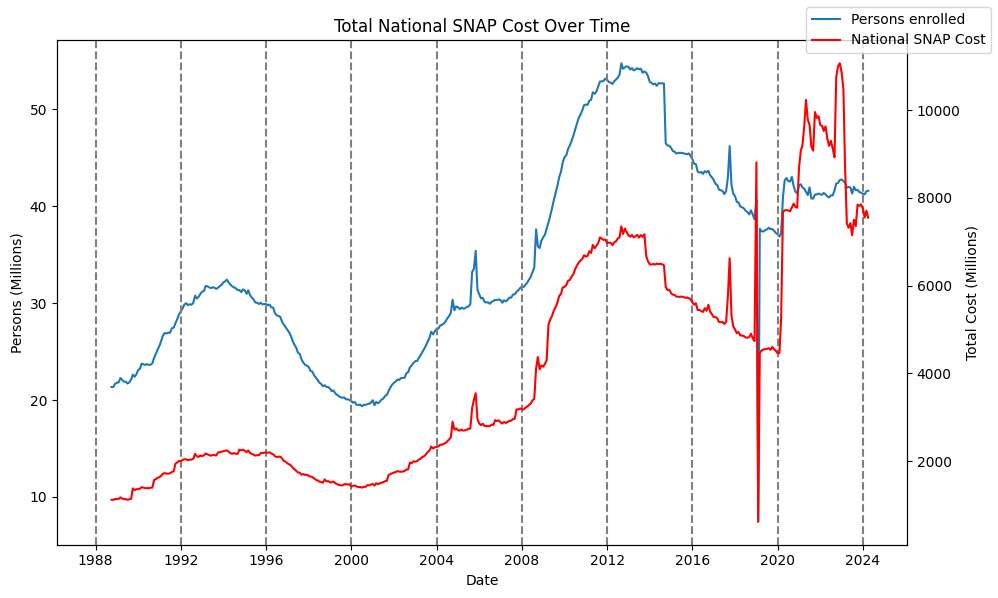

In [174]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.plot(national_snap['Date'], national_snap['Persons'] / 1e6, label='Persons enrolled')
ax1.set_title('Total National SNAP Cost Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Persons (Millions)')

for year in range(1988, 2028, 4):
    ax1.axvline(pd.to_datetime(str(year) + '-01-01'), color='gray', linestyle='--')

ax2.plot(national_snap['Date'], national_snap['Cost'] / 1e6, label='National SNAP Cost', color='red')
ax2.set_ylabel('Total Cost (Millions)')

fig.legend()
plt.tight_layout()
plt.show()

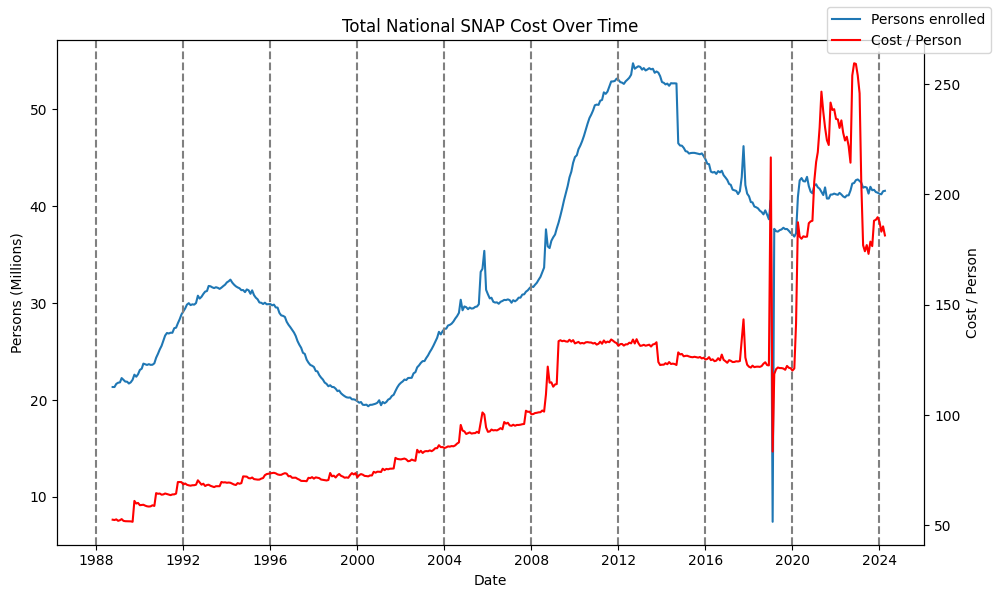

In [173]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.plot(national_snap['Date'], national_snap['Persons'] / 1e6, label='Persons enrolled')
ax1.set_title('Total National SNAP Cost Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Persons (Millions)')

for year in range(1988, 2028, 4):
    ax1.axvline(pd.to_datetime(str(year) + '-01-01'), color='gray', linestyle='--')

ax2.plot(national_snap['Date'], national_snap['Benefit / Persons'], label='Cost / Person', color='red')
ax2.set_ylabel('Cost / Person')

fig.legend()
plt.tight_layout()
plt.show()